# Math (GARCH 1,1)

$$r_t = \epsilon_t + \mu$$
$$\epsilon_t = \sigma_tz_t$$
$$z_t \sim N(0,1)\text{, iid}$$
$$\sigma^2_{t+1} = \omega + \alpha\epsilon_t^2 + \beta\sigma^2_{t}$$


last equation is the key equation in GARCH, we forecast tomorrow's volatility as a sum of
1. a long term average $\omega$
2. today's shock (what we actually observe at time t) 
3. yesterday's forecast (conditional variance)

**We assumes that $\epsilon_t$ (todays return) follows a normal distribution** with mean 0 and variance $\sigma_t^2$, notice that this $\sigma_t^2$ is the forecast we made yesterday -> our conditional volatility

For the process to be stationary, we also require $1-\alpha-\beta>0$

Thus, we can do MLE and calculate the **log likelihood function**, given by

$$l(\theta) = -\frac{T}{2}ln(2\pi) - \frac{1}{2}\sum_{t=1}^{T}ln(\sigma^2_t) - \frac{1}{2}\sum_{t=1}^T\frac{\epsilon_t^2}{\sigma_t^2}$$

In our model GARCH(1,1), there are 4 parameters
1. $\mu$: average return
2. $\omega$: long term average variance
3. $\alpha$: How much a recent shock (large return) affects future volatility
4. $\beta$: How much past volatility influences future volatility -> controls how 'persistant' volatility is

It is important to note that in GARCH, the **UNCONDITIONAL VARIANCE** is denoted by 
$$\frac{\omega}{1-\alpha-\beta}

# Model

In [ ]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt

def negative_log_likelihood(params, returns):
    """Negative log-likelihood (we minimize this)"""
    mu, omega, alpha, beta = params
    
    # Check constraints
    if omega <= 1e-8 or alpha < 0 or beta < 0 or alpha + beta >= 0.999:
        return 1e10  
    
    n = len(returns)
    epsilon = returns - mu
    
    # Initialize variance
    sigma2 = np.zeros(n)
    sigma2[0] = omega / (1 - alpha - beta)
    
    # Recursive variance calculation
    for t in range(1, n):
        sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
    
    # Log-likelihood
    llf = -0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + epsilon**2 / sigma2)
    
    return -llf  # Return negative for minimization

In [ ]:
# Generate synthetic financial returns data
np.random.seed(42)
n = 1000
returns = np.random.randn(n) * 0.01  

initial_guess = [0.0, 0.0001, 0.1, 0.8]
bounds = [(-0.1, 0.1), (1e-8, 0.1), (0, 1), (0, 1)]

result = minimize(
    negative_log_likelihood,
    initial_guess,
    args=(returns,),
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000, 'ftol': 1e-10}
)

# Analysis 

### 1. Synethic random (normal) return (no clustering)

In [ ]:
drifts = np.arange(0.01,0.2,0.01)
vols = np.arange(0.01,0.5,0.01)
n=1000
initial_guess = [0.0, 0.0001, 0.1, 0.8]
bounds = [(-1, 1), (1e-8, 0.5), (0, 1), (0, 1)]

results = []
for drift in drifts:
    for vol in vols:
        synthetic_returns = drift + vol * np.random.randn(n)
        result = minimize(
            negative_log_likelihood,
            initial_guess,
            args=(synthetic_returns,),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000, 'ftol': 1e-10}
        )
        if result.success:
            results.append({
                'drift': drift,
                'vol': vol,
                'mu': result.x[0],
                'omega': result.x[1],
                'alpha': result.x[2],
                'beta': result.x[3],
                'neg_log_likelihood': result.fun
            })

results_df = pd.DataFrame(results)

In [ ]:
# run model using official garch package for checking (it's correct)
from arch import arch_model

drifts = np.arange(0.01,0.2,0.01)
vols = np.arange(0.01,0.5,0.01)
n=1000
results = []
for drift in drifts:
    for vol in vols:
        synthetic_returns = drift + vol * np.random.randn(n)
        model = arch_model(synthetic_returns, vol='GARCH', p=1, q=1)
        result = model.fit(update_freq=5) 
        
        results.append({
            'drift': drift,
            'vol': vol,
            'mu': result.params[0],
            'omega': result.params[1],
            'alpha': result.params[2],
            'beta': result.params[3],
            'neg_log_likelihood': result.loglikelihood
        })

results_df = pd.DataFrame(results)

Text(0.5, 1.0, 'Synthetic Financial Returns: Drift 0.19, Volatility 0.49')

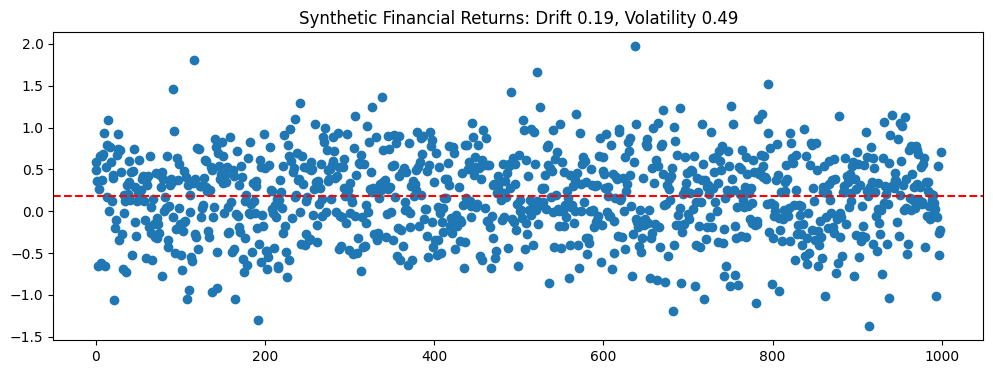

In [89]:
plt.figure(figsize=(12,4))
plt.scatter(x=range(len(synthetic_returns)),y=synthetic_returns)
plt.axhline(y=np.mean(synthetic_returns), color='r', linestyle='--')
plt.title('Synthetic Financial Returns: Drift {drift}, Volatility {vol}'.format(drift=drift, vol=vol))

Text(0.5, 1.0, 'Synthetic Financial Returns: Drift 0.19, Volatility 0.49')

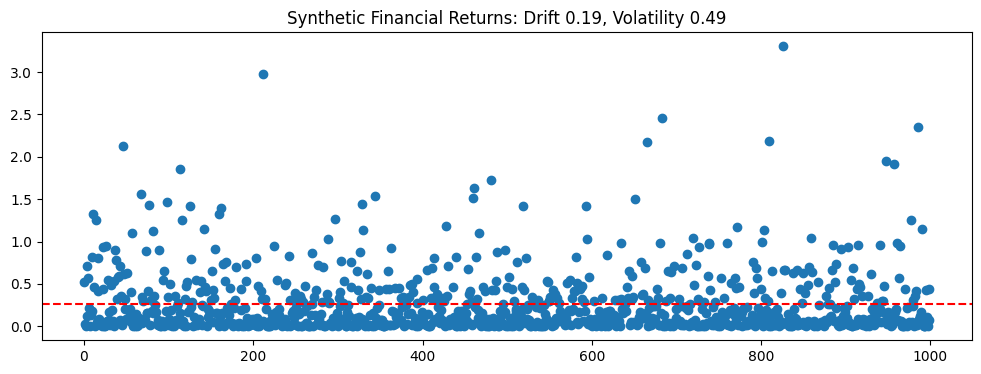

In [25]:
plt.figure(figsize=(12,4))
plt.scatter(x=range(len(synthetic_returns)),y=synthetic_returns**2)
plt.axhline(y=np.mean(synthetic_returns**2), color='r', linestyle='--')
plt.title('Synthetic Financial Returns: Drift {drift}, Volatility {vol}'.format(drift=drift, vol=vol))

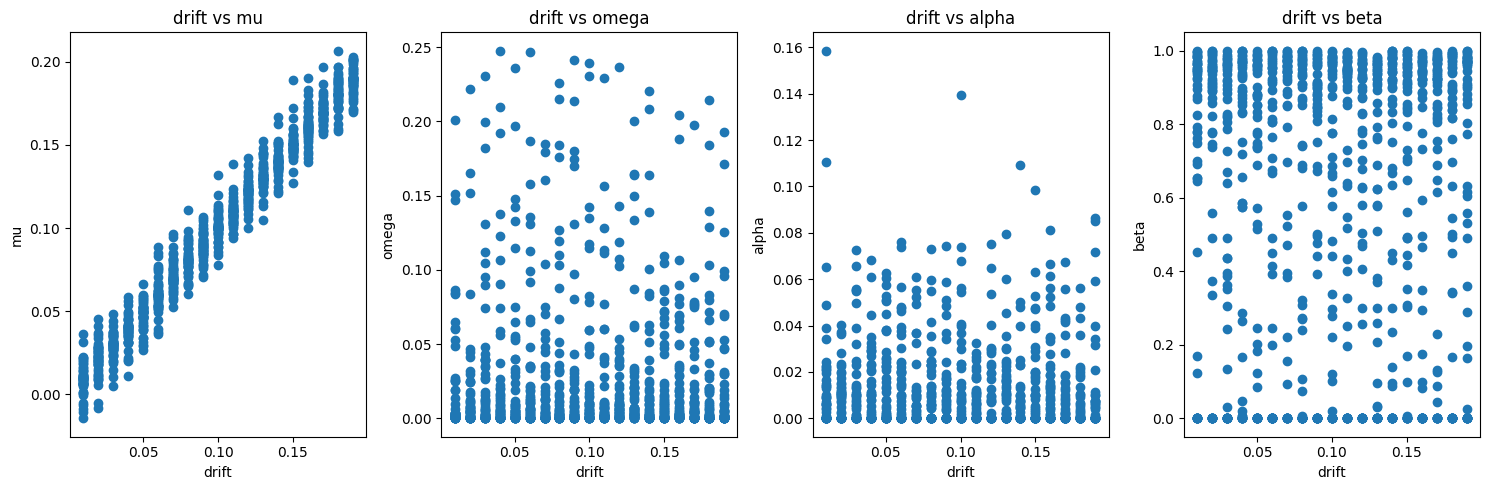

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))


# Plot 1: drift vs mu
axes[0].scatter(x=results_df['drift'], y=results_df['mu'])
axes[0].set_xlabel('drift')
axes[0].set_ylabel('mu')
axes[0].set_title('drift vs mu')

# Plot 1: drift vs omega
axes[1].scatter(x=results_df['drift'], y=results_df['omega'])
axes[1].set_xlabel('drift')
axes[1].set_ylabel('omega')
axes[1].set_title('drift vs omega')

# Plot 2: drift vs alpha
axes[2].scatter(x=results_df['drift'], y=results_df['alpha'])
axes[2].set_xlabel('drift')
axes[2].set_ylabel('alpha')
axes[2].set_title('drift vs alpha')

# Plot 3: drift vs beta
axes[3].scatter(x=results_df['drift'], y=results_df['beta'])
axes[3].set_xlabel('drift')
axes[3].set_ylabel('beta')
axes[3].set_title('drift vs beta')

# # Plot 4: drift vs neg log likelihood
# axes[3].scatter(x=results_df['drift'], y=results_df['neg_log_likelihood'])
# axes[3].set_xlabel('drift')
# axes[3].set_ylabel('neg_log_likelihood')
# axes[3].set_title('drift vs neg_log_likelihood')

plt.tight_layout()
plt.show()

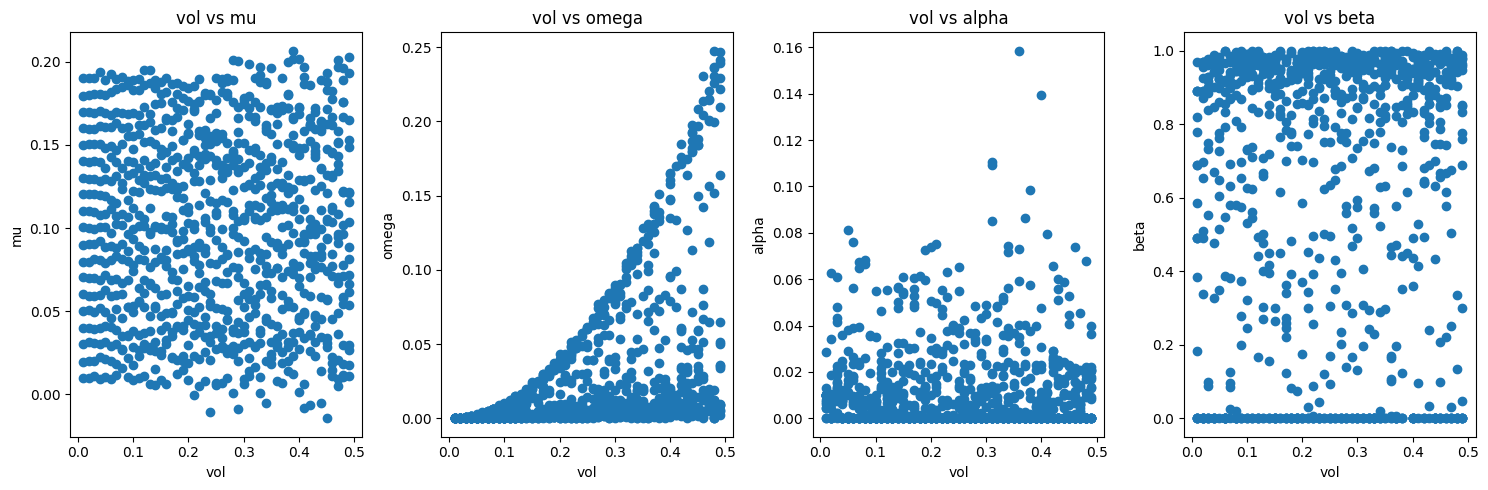

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))


axes[0].scatter(x=results_df['vol'], y=results_df['mu'])
axes[0].set_xlabel('vol')
axes[0].set_ylabel('mu')
axes[0].set_title('vol vs mu')

# Plot 1: vol vs omega
axes[1].scatter(x=results_df['vol'], y=results_df['omega'])
axes[1].set_xlabel('vol')
axes[1].set_ylabel('omega')
axes[1].set_title('vol vs omega')

# Plot 2: vol vs alpha
axes[2].scatter(x=results_df['vol'], y=results_df['alpha'])
axes[2].set_xlabel('vol')
axes[2].set_ylabel('alpha')
axes[2].set_title('vol vs alpha')

# Plot 3: vol vs beta
axes[3].scatter(x=results_df['vol'], y=results_df['beta'])
axes[3].set_xlabel('vol')
axes[3].set_ylabel('beta')
axes[3].set_title('vol vs beta')

# # Plot 4: vol vs neg log likelihood
# axes[3].scatter(x=results_df['vol'], y=results_df['neg_log_likelihood'])
# axes[3].set_xlabel('vol')
# axes[3].set_ylabel('neg_log_likelihood')
# axes[3].set_title('vol vs neg_log_likelihood')

plt.tight_layout()
plt.show()

### 2. Visualize synthetic GARCH return 

In [72]:
def simulate_garch(n, omega=0.05, alpha=0.1, beta=0.85, mu=0.0, seed=None):
    """
    simulate garch(1,1) process
    """
    if seed is not None:
        np.random.seed(seed)
    
    returns = np.zeros(n)
    sigma2 = np.zeros(n)  
    
    # Initial variance (unconditional)
    sigma2[0] = omega / (1 - alpha - beta)
    returns[0] = mu + np.sqrt(sigma2[0]) * np.random.randn()
    
    for t in range(1, n):
        # Update conditional variance
        sigma2[t] = omega + alpha * (returns[t-1] - mu)**2 + beta * sigma2[t-1]
        
        # Generate return
        returns[t] = mu + np.sqrt(sigma2[t]) * np.random.randn()
    
    return returns, sigma2

n = 1000
mu = 0.001
omega = 0.05
alpha = 0.8
beta = 0.00001
returns, variance = simulate_garch(n, omega=omega, alpha=alpha, beta=beta, mu=mu)

#### High beta, low alpha

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Create the figure
fig = go.Figure()

# Add scatter plot for returns
fig.add_trace(go.Scatter(
    x=list(range(len(returns))),
    y=returns,
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.7,
        color='blue',
        symbol='circle'
    ),
    name='Returns',
    hovertemplate='Period: %{x}<br>Return: %{y:.4f}<extra></extra>'
))

# Add horizontal line for mean
mean_return = np.mean(returns)
fig.add_trace(go.Scatter(
    x=[0, len(returns)-1],
    y=[mean_return, mean_return],
    mode='lines',
    line=dict(color='red', dash='dash', width=2),
    name=f'Mean: {mean_return:.4f}',
    hovertemplate='Mean Return: %{y:.4f}<extra></extra>'
))

# Update layout
fig.update_layout(
    title=dict(
        text=f'Synthetic Financial Returns: Drift {mu:.3f}, Omega {omega:.3f}, Alpha {alpha:.3f}, Beta {beta:.3f}',
        font=dict(size=14, family='Arial')
    ),
    xaxis_title='Time Period',
    yaxis_title='Return',
    hovermode='x unified',
    template='plotly_white',
    showlegend=True,
    width=1200,
    height=500,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Add annotation for statistics
fig.add_annotation(
    xref='paper', yref='paper',
    x=0.02, y=0.98,
    text=f'Mean: {mean_return:.4f}<br>Std: {np.std(returns):.4f}<br>Min: {np.min(returns):.4f}<br>Max: {np.max(returns):.4f}',
    showarrow=False,
    font=dict(size=11),
    bgcolor='lightyellow',
    bordercolor='black',
    borderwidth=1,
    borderpad=4
)

fig.show()

In [69]:
import plotly.graph_objects as go
import numpy as np

# Assuming you have these variables defined
# variance = your variance array
# mu, omega, alpha, beta = your parameters

# Create the figure
fig = go.Figure()

# Add scatter plot for variance
fig.add_trace(go.Scatter(
    x=list(range(len(variance))),
    y=variance,
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.6,
        color='blue'
    ),
    name='Conditional Variance'
))

# Add horizontal line for mean
mean_variance = np.mean(variance)
fig.add_trace(go.Scatter(
    x=[0, len(variance)-1],
    y=[mean_variance, mean_variance],
    mode='lines',
    line=dict(color='red', dash='dash', width=2),
    name=f'Mean: {mean_variance:.4f}'
))

# Calculate unconditional variance
uncond_var = omega / (1 - alpha - beta)

# Update layout
fig.update_layout(
    title=dict(
        text=f'Variance: Drift {mu:.3f}, Omega {omega:.3f}, Alpha {alpha:.3f}, Beta {beta:.3f}, Unconditional Variance {uncond_var:.3f}',
        font=dict(size=14)
    ),
    xaxis_title='Time Period',
    yaxis_title='Variance',
    hovermode='x unified',
    template='plotly_white',  # or 'plotly_dark', 'ggplot2', 'seaborn'
    showlegend=True,
    width=1200,
    height=500
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()

#### High alpha, low beta

In [74]:
import plotly.graph_objects as go
import numpy as np

# Create the figure
fig = go.Figure()

# Add scatter plot for returns
fig.add_trace(go.Scatter(
    x=list(range(len(returns))),
    y=returns,
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.7,
        color='blue',
        symbol='circle'
    ),
    name='Returns',
    hovertemplate='Period: %{x}<br>Return: %{y:.4f}<extra></extra>'
))

# Add horizontal line for mean
mean_return = np.mean(returns)
fig.add_trace(go.Scatter(
    x=[0, len(returns)-1],
    y=[mean_return, mean_return],
    mode='lines',
    line=dict(color='red', dash='dash', width=2),
    name=f'Mean: {mean_return:.4f}',
    hovertemplate='Mean Return: %{y:.4f}<extra></extra>'
))

# Update layout
fig.update_layout(
    title=dict(
        text=f'Synthetic Financial Returns: Drift {mu:.3f}, Omega {omega:.3f}, Alpha {alpha:.3f}, Beta {beta:.3f}',
        font=dict(size=14, family='Arial')
    ),
    xaxis_title='Time Period',
    yaxis_title='Return',
    hovermode='x unified',
    template='plotly_white',
    showlegend=True,
    width=1200,
    height=500,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Add annotation for statistics
fig.add_annotation(
    xref='paper', yref='paper',
    x=0.02, y=0.98,
    text=f'Mean: {mean_return:.4f}<br>Std: {np.std(returns):.4f}<br>Min: {np.min(returns):.4f}<br>Max: {np.max(returns):.4f}',
    showarrow=False,
    font=dict(size=11),
    bgcolor='lightyellow',
    bordercolor='black',
    borderwidth=1,
    borderpad=4
)

fig.show()

In [73]:
import plotly.graph_objects as go
import numpy as np

# Assuming you have these variables defined
# variance = your variance array
# mu, omega, alpha, beta = your parameters

# Create the figure
fig = go.Figure()

# Add scatter plot for variance
fig.add_trace(go.Scatter(
    x=list(range(len(variance))),
    y=variance,
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.6,
        color='blue'
    ),
    name='Conditional Variance'
))

# Add horizontal line for mean
mean_variance = np.mean(variance)
fig.add_trace(go.Scatter(
    x=[0, len(variance)-1],
    y=[mean_variance, mean_variance],
    mode='lines',
    line=dict(color='red', dash='dash', width=2),
    name=f'Mean: {mean_variance:.4f}'
))

# Calculate unconditional variance
uncond_var = omega / (1 - alpha - beta)

# Update layout
fig.update_layout(
    title=dict(
        text=f'Variance: Drift {mu:.3f}, Omega {omega:.3f}, Alpha {alpha:.3f}, Beta {beta:.3f}, Unconditional Variance {uncond_var:.3f}',
        font=dict(size=14)
    ),
    xaxis_title='Time Period',
    yaxis_title='Variance',
    hovermode='x unified',
    template='plotly_white',  # or 'plotly_dark', 'ggplot2', 'seaborn'
    showlegend=True,
    width=1200,
    height=500
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()

### 3. Extension - Custom Log Likelihood function